 # Prognozowanie szeregów czasowych (time series forecasting) 

Ten tutorial autostwa tworców TensorFlow jest wstępem do prognozowania szeregów czasowych z użyciem tej biblioteki. Pokazuje jak zbudować kilka różnych rodzajó modeli dla tego problemu, uwzgędniając CNN i RNN
Tutorial ma dwie części

* Prognoza dla jednego kroku czasowego:
  * przy jednej zmiennej.
  * przy wielu zmiennych.
* Prognoza dla wielu kroków czasowych
  * Single-shot: prognoza wszystkich wartości naraz.
  * Autoregresyjna: jedna wartość naraz i podanie jej z powrotem jako wejście do modelu w celu prognozy kolejnej wartości

## Zależności

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## Zbiór danych
Tutorial używa zbioru <a href="https://www.bgc-jena.mpg.de/wetter/" class="external">weather time series dataset</a> zebranego przez <a href="https://www.bgc-jena.mpg.de" class="external">Max Planck Institute for Biogeochemistry</a>.

Zawiera on 14 różnych cech takich jak temperatura powietrza, ciśnienie, wilgotność itd. Wartości były zbierane co 10 minut, od 2003 roku. Będziemy używać jedynie danych między 2009 a 2016 rokiem. Ta część została przygotowana przez François Cholleta do książki [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).

In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

Będziemy działać na **odczytach cogodzinnych**, dokonajmy więc resamplingu danych z 10 minut na 1h:

In [ ]:
df = pd.read_csv(csv_path)
# slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

Spójrzmy jak wyglądają dane:

In [ ]:
df.head()

A tak wygląda zmiana tych wartości w czasie

In [ ]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

### Analiza i czyszczenie danych

Spójrzmy na statystyki zbioru:

In [ ]:
df.describe().transpose()

#### Prędkość wiatru (wind velocity)

Jedna rzecz powinna zwrócić naszą uwagę - wartość kolumny `min` dla wierszy `wv (m/s)` and `max. wv (m/s)`. Wartość `-9999` jest zdecydowanie błędna. Istnieje oddzielny wiersz dla kierunku wiatru, więc prędkość powinna być `>=0`. Zastąpmy błędne wartość zerami.

In [ ]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# Spójrzmy czy w dataframe'ie też się to zmieniło
df['wv (m/s)'].min()

### Inżynieria cech (feature enginnering)

Przed przystąpieniem do tworzenia modelu ważne jest zrozumienie swoich danych i upewnienie się, że przekazujesz modelowi odpowiednio sformatowane dane.

#### Wiatr
Ostatnia kolumna danych, `wd (deg)`, podaje kierunek wiatru w jednostkach stopni. Kąty nie są dobrymi danymi wejściowymi do modelu, 360° i 0° powinny być zbliżone do siebie i płynnie owijać się wokół siebie. Kierunek nie powinien mieć znaczenia, jeśli wiatr nie wieje. 

W tej chwili rozkład danych dotyczących wiatru wygląda następująco:

In [ ]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

Model będzie mógł to łatwiej zinterpretować, jeśli kolumny kierunku i prędkości wiatru zostaną zamienione na **wektor wiatru**:

In [ ]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Konwertujemy do radianów
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Obliczamy składowe x i y wiatru.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Obliczamy maksymalne składowe x i y wiatru
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

Rozkład wektorów wiatru jest znacznie prostszy do prawidłowej interpretacji przez model.

In [ ]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

#### Czas

Kolumna `Date Time` jest użyteczna ale nie w formie łańcucha znaków, zamieńmy ją na timestamp:

In [ ]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

Czas w sekundach nadal jednak nie odwzorowuje dobrze cykliczności czasu. Prostym sposobem odwzorowania tej cykliczności pory dnia i pory roku jest zastosowanie funkcji `sin` i `cos`

In [ ]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [ ]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

W ten sposób model uzyskuje dostęp do najważniejszych cech częstotliwości. W tym przypadku wiedzieliśmy już wcześniej, które częstotliwości są ważne. 

Jeśli nie jest to wiadome, można to określić, używając `fft` (czyli szybkiej transformacji Fouriera). Aby sprawdzić nasze założenia, oto wykres `tf.signal.rfft` temperatury w czasie. Zwróć uwagę na wyraźne szczyty przy częstotliwościach bliskich `1/rok` i `1/dzień`: 

In [ ]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

### Podzielmy dane

Użyjemy podziału `(70%, 20%, 10%)` dla terningu, walidacji i testu. Zauważ że nie mieszamy danych losowo, przy danych sekwencyjnych nie jest to pomocne.

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### Znormalizujmy dane

normalizujemy dane z użyciem wyłącznie średniej i odchylenia standardowego danych treningowych

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Zobaczmy rozkład danych, niektóre z nich mają długie "ogony" ale nie pojawiają się oczywiste błędy jak ujemna prędkość wiatru

In [ ]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Okienkowanie danych (Data windowing)

Modele w tym samouczku wykonują zestaw przewidywań na podstawie okna kolejnych próbek danych. 

Główne cechy okien wejściowych to:

* Szerokość (liczba kroków czasowych) okna wejściowego i okna etykiet.
* Przesunięcie czasowe między nimi.
* Które cechy są używane jako dane wejściowe, etykiety lub obie. 

Tutorial buduje różne modele (w tym modele liniowe, DNN, CNN i RNN) i wykorzystuje je zarówno do:

* *Single-output* (jednowyjściowych) i *multi-output* (wielowyjściowych) prognoz
* *Single-time-step* (jednokrokowych) i *multi-time-step* (wielokrokowych) predictions.

W tym rozdziale skupiono się na implementacji okienkowania danych w taki sposób, aby można je było ponownie wykorzystać we wszystkich tych modelach.

W zależności od zadania i typu modelu może być konieczne wygenerowanie różnych okien danych. Oto kilka przykładów:

1. Na przykład, aby dokonać pojedynczej prognozy na 24 godziny w przyszłości, biorąc pod uwagę 24 godziny historii, można zdefiniować takie okno:

  ![One prediction 24h into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_24h.png?raw=1)

2. Model, który przewiduje 1 godzinę w przyszłości, mając do dyspozycji 6 godzin historii, musiałby mieć takie okno:

  ![One prediction 1h into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_1h.png?raw=1)

Pozostała część tej sekcji definiuje klasę `WindowGenerator`. Klasa ta może:

1. Obsługiwać indeksy i przesunięcia, jak pokazano na diagramach powyżej.
1. Rozdzielać okna cech na pary `(cechy, etykiety)`.
2. Zwizualizować zawartość powstałych w ten sposób okien.
3. Efektywnie wygenerować batche tych okien z danych treningowych, ewaluacyjnych i testowych, używając `tf.data.Dataset`.

### 1. Indeksy i przesunięcia

Zacznijmy od utworzenia klasy `WindowGenerator`. Metoda `__init__` zawiera całą niezbędną logikę dla indeksów wejściowych i etykiet.

Pobiera ona również ramki danych train, eval i test jako dane wejściowe. Zostaną one później przekonwertowane do `tf.data.Dataset` dla okien.

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Przechowujemy dane wejściowe.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Oblicz indeksy kolumn etykiet.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Oblicz parametry okna.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Poniżej znajduje się kod umożliwiający utworzenie dwóch okien pokazanych na diagramach na początku tego rozdziału:

In [ ]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

In [ ]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

### 2. Split
Metoda `split_window`, mając do dyspozycji listę kolejnych wejść, przekształca je w okno wejść i okno etykiet.

Powyższy przykład `w2` zostanie podzielony w ten sposób:

![The initial window is all consecuitive samples, this splits it into an (inputs, labels) pairs](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/split_window.png?raw=1)

Ten diagram nie pokazuje osi `cech` danych, ale funkcja `split_window` obsługuje również `label_columns`, więc może być używana zarówno dla przykładów z jednym wyjściem, jak i z wieloma wyjściami.

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing nie zachowuje statycznych informacji o kształcie, więc należy ustawić kształty ręcznie. W ten sposób zbiory danych `tf.data.Datasets` są łatwiejsze do sprawdzenia.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

Try it out:

In [ ]:
# Stwórzmy stos trzech slice'ów o długości całego okna:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

Zazwyczaj dane w TensorFlow są upakowane w arraye, w których najbardziej zewnętrzny indeks dotyczy przykładów (wymiar "batchu"). Indeksy środkowe to wymiar (wymiary) "czasowy" lub "przestrzenny" (szerokość, wysokość). Najbardziej wewnętrzne indeksy to cechy.

Powyższy kod wziął batch 3 okien o 7 krokach czasowych, z 19 cechami na każdym kroku czasowym. Podzielił je na batch 6 okien o 6 krokach czasowych i 19 cechach wejściowych oraz na etykietę z 1 cechą w 1 kroku czasowym. Etykieta ma tylko jedną cechę, ponieważ `WindowGenerator` został zainicjowany tylko z `label_columns=['T (degC)']`. Początkowo ten samouczek będzie budował modele przewidujące pojedyncze etykiety wyjściowe.

### 3. Wizualizacja

Poniżej przedstawiono metodę tworzenia wykresu, która umożliwia prostą wizualizację podzielonego okna:

In [ ]:
w2.example = example_inputs, example_labels

In [ ]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

Ten wykres wyrównuje dane wejściowe, etykiety i (później) przewidywania na podstawie czasu, do którego odnosi się dany element:

In [ ]:
w2.plot()

Można wykreślić inne kolumny, ale przykładowa konfiguracja okna `w2` ma etykiety tylko dla kolumny `T (degC)`.

In [ ]:
w2.plot(plot_col='p (mbar)')

### 4. Tworzenie `tf.data.Dataset`

Finalnie metoda `make_dataset` pobierze szereg czasowy `DataFrame` i przekształci go w `tf.data.Dataset` dla par `(input_window, label_window)` przy użyciu funkcji `preprocessing.timeseries_dataset_from_array`.

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

Obiekt `WindowGenerator` przechowuje dane treningowe, walidacyjne i testowe. Dodajmy właściwości umożliwiające dostęp do nich jako `tf.data.Datasets` za pomocą powyższej metody `make_dataset`. Dodajmy również standardowy przykładowy batch dla łatwego dostępu i tworzenia wykresów:

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # Żaden batch nie został znaleziony, więc pobierzmy jeden ze zbioru `.train`
    result = next(iter(self.train))
    # i zachowajmy go
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Teraz obiekt `WindowGenerator` daje dostęp do obiektów `tf.data.Dataset`, dzięki czemu można łatwo iterować po danych.

Właściwość `Dataset.element_spec` mówi o strukturze, `dtypes` i kształtach elementów zbioru danych.

In [ ]:
# Każdy element to para (wejścia, etykieta)
w2.train.element_spec

Iteracja po zbiorze danych daje teraz konkretne batche:

In [ ]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

## Modele jednokrokowe

Najprostszym modelem, jaki można zbudować na tego typu danych, jest model przewidujący wartość pojedynczej cechy, 1 krok czasowy (1h) w przyszłości, tylko na podstawie bieżących warunków.

Zacznijmy więc od zbudowania modelu przewidującego wartość `T (degC)` na 1h w przyszłości.

![Predict the next time step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/narrow_window.png?raw=1)

Skonfigurujmy obiekt `WindowGenerator` do tworzenia takich jednokrokowych par `(input, label)`:

In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Obiekt `window` tworzy `tf.data.Datasets` ze zbiorów treningowych, walidacyjnych i testowych, co pozwala na łatwe iterowanie po batchach danych.

In [ ]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

### Baseline (model trywialny)

Przed zbudowaniem modelu, który można wytrenować, dobrze byłoby mieć baseline, który posłuży za punkt odniesienia do porównania z późniejszymi, bardziej skomplikowanymi modelami.

Pierwsze etap polega na przewidywaniu temperatury na 1 godzinę w przyszłości na podstawie bieżących wartości wszystkich cech. Bieżące wartości obejmują bieżącą temperaturę. 

Zacznijmy więc od modelu, który jako prognozę zwraca tylko bieżącą temperaturę, przewidując "Bez zmian". Jest to rozsądny punkt odniesienia, ponieważ temperatura zmienia się powoli. Oczywiście ten punkt odniesienia będzie działał gorzej, jeśli przewidywania będą sięgać dalej w przyszłość.

![Send the input to the output](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/baseline.png?raw=1)

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

Zainicjalizujmy i oceńmy ten model:

In [ ]:
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

Wypisuje to pewne wskaźniki wydajności, ale nie dają one poczucia, jak dobrze model sobie radzi.

Generator `WindowGenerator` ma metodę wykresu, ale wykresy nie będą zbyt interesujące przy pojedynczej próbce. Utwórzmy więc szerszy `WindowGenerator`, który generuje okna 24h z kolejnymi wejściami i etykietami naraz. 

Okno `wide_window` nie zmienia sposobu działania modelu. Model nadal tworzy prognozy na 1 godzinę w przyszłość na podstawie pojedynczego wejściowego kroku czasowego. Tutaj oś `time` działa jak oś `batch`: Każde przewidywanie jest wykonywane niezależnie, bez interakcji między krokami czasowymi.

In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Takie rozszerzone okno można przekazać bezpośrednio do tego samego modelu `baseline` bez żadnych zmian w kodzie. Jest to możliwe, ponieważ dane wejściowe i etykiety mają taką samą liczbę kroków czasowych, a linia bazowa po prostu przekazuje dane wejściowe do danych wyjściowych:

  ![One prediction 1h into the future, ever hour.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/last_window.png?raw=1)

In [ ]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', baseline(single_step_window.example[0]).shape)

Wykreślając prognozy modelu podstawowego, można zauważyć, że są to po prostu etykiety przesunięte w prawo o 1h.

In [ ]:
wide_window.plot(baseline)

### Model liniowy

Najprostszy **trenowalny** model, który można zastosować do tego zadania, polega na wprowadzeniu liniowej transformacji między wejściem a wyjściem. W tym przypadku dane wyjściowe z danego kroku czasowego zależą tylko od tego kroku:

![A single step prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/narrow_window.png?raw=1)

In [ ]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Zapakujmy w jedną funkcję wszystkie procedury które przydadzą się do następnych modeli

In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Wytrenujmy model i oceńmy działanie

In [ ]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Podobnie jak `baseline`, model liniowy może być wywoływany na batchach szerszych okien. W ten sposób model tworzy zestaw niezależnych przewidywań w odpowiednich krokach czasowych. Oś `time` działa jak kolejna oś `batch`. Nie ma żadnych interakcji między predykcjami w każdym kroku czasowym.

![A single step prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/wide_window.png?raw=1)

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Oto wykres przykładowych przewidywań dla `wide_window`, zauważ, że w wielu przypadkach przewidywanie jest wyraźnie lepsze niż zwracanie temperatury wejściowej, ale w kilku przypadkach jest gorsze

In [ ]:
wide_window.plot(linear)

Jedną z zalet modeli liniowych jest to, że są one stosunkowo łatwe do zinterpretowania.
Można wyciągnąć wagi warstw i zobaczyć, jaka waga jest przypisana do każdego wejścia

In [ ]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

Czasami model nie przykłada żadnej wagi do którejś danej wejściowej (`T (degC)`). Jest to jedno z zagrożeń związanych z losową inicjalizacją. 

### Dense

Przed zastosowaniem modeli, które faktycznie działają na wielu krokach czasowych, warto sprawdzić działanie głębszych, bardziej wydajnych modeli z jednym krokiem wejściowym.

Oto model z zastosowaniem warstw gęstych 

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

In [ ]:
wide_window.plot(dense)

### Multi-step dense

Model jednkrokowy nie ma kontekstu dla bieżących wartości danych wejściowych. Nie może zobaczyć, jak cechy wejściowe zmieniają się w czasie. Aby rozwiązać ten problem, model musi mieć dostęp do wielu kroków czasowych podczas tworzenia prognoz:

![Three time steps are used for each prediction.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/conv_window.png?raw=1)


Modele `baseline`, `linear` i `dense` traktują każdy krok czasowy niezależnie. W tym przypadku model będzie przyjmował wiele kroków czasowych jako dane wejściowe, aby otrzymać jedno wyjście.

Utwórzmy `WindowGenerator`, który będzie produkował batche 3h danych wejściowych i 1h etykiet:

In [ ]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

conv_window

In [ ]:
conv_window.plot()
plt.title("Given 3h as input, predict 1h into the future.")

Można wytrenować model `dense` na oknie z wieloma krokami wejściowymi, dodając wypłaszczenie jako pierwszą warstwę modelu:

In [ ]:
multi_step_dense = tf.keras.Sequential([
    tf.keras.layers.Flatten(),  # (time, features) => (time*features)
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1, -1]), # powrót do wymiaru czasowego: (outputs) => (1, outputs)
])

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

In [ ]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

In [ ]:
conv_window.plot(multi_step_dense)

Główną wadą tego podejścia jest to, że model wynikowy może być wykonany tylko na oknach wejściowych o **dokładnie** takim kształcie. 

In [ ]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Modele konwolucyjne rozwiązują ten problem.

### Convolution neural network
 
Warstwa konwolucji (`layers.Conv1D`) również przyjmuje wiele kroków czasowych jako dane wejściowe do każdego przewidywania.

Poniżej znajduje się **ten sam** model co `multi_step_dense`, napisany na nowo z zastosowaniem konwolucji. 

Zmiany:
* `layers.Flatten` i pierwszy `layers.Dense` zostały zastąpione przez `layers.Conv1D`.
* `layers.Reshape` nie jest już potrzebna, ponieważ konwolucja zachowuje oś czasu na wyjściu.

In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=(CONV_WIDTH,), activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

Uruchommy go na przykładowym batchu, aby sprawdzić, czy model generuje dane wyjściowe o oczekiwanym kształcie:

In [ ]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Przetrenujmy i oceńmy go na `conv_window`, a powinien on dać wydajność podobną do modelu `multi_step_dense`.

In [ ]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

Różnica między `conv_model` a modelem `multi_step_dense` polega na tym, że `conv_model` może być uruchamiany na danych wejściowych o dowolnej długości. Warstwa konwolucyjna jest stosowana do przesuwanego okna danych wejściowych:

![Executing a convolutional model on a sequence](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/wide_conv_window.png?raw=1)

Jeśli uruchomimy go na szerszym wejściu, daje szerszy sygnał wyjściowy:

In [ ]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Zauważ, że dane wyjściowe są krótsze niż dane wejściowe. Aby trening i wizualizacja działały, etykiety i przewidywania muszą mieć taką samą długość. Zbudujmy więc `WindowGenerator`, który wytworzy szerokie okna z kilkoma dodatkowymi krokami czasowymi na wejściu, aby długość etykiet i przewidywań była taka sama: 

In [ ]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

wide_conv_window

In [ ]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Teraz możemy wykreślić przewidywania modelu w szerszym oknie. Zwróć uwagę na 3 wejściowe kroki czasowe przed pierwszym przewidywaniem. Każde przewidywanie jest oparte na trzech poprzednich krokach czasowych:

In [ ]:
wide_conv_window.plot(conv_model)

### Sieć rekurencyjna

RNN dobrze się sprawdza do predykcji szeregów czasowych. Sieci RNN przetwarzają szeregi czasowe krok po kroku, zachowując stan wewnętrzny z kroku na krok.

Użyjemy tu konkretnie warstwy LSTM ([LSTM](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM)).

Ważnym argumentem konstruktora dla wszystkich warstw keras RNN jest argument `return_sequences`. To ustawienie może skonfigurować warstwę na jeden z dwóch sposobów.

1. Jeśli ustawiono domyślnie wartość `False`, warstwa zwraca tylko dane wyjściowe z ostatniego kroku czasowego, dając modelowi czas na `rozgrzanie` swojego stanu wewnętrznego przed wykonaniem pojedynczego przewidywania:

![An lstm warming up and making a single prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_1_window.png?raw=1)

2. Jeśli ustawiono na `True`, warstwa zwraca wyjście dla każdego wejścia. Jest to przydatne do:
  * układania warstw RNN. 
  * treningu modelu na wielu krokach czasowych jednocześnie.

![An lstm making a prediction after every timestep](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_many_window.png?raw=1)

In [ ]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True), #[batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Dense(units=1) #[batch, time, features]
])

Przy `return_sequences=True` model może być trenowany na danych z 24 godzin na raz.

Uwaga: daje to pesymistyczny obraz wydajności modelu. W pierwszym kroku czasowym model nie ma dostępu do poprzednich kroków, a więc nie może działać lepiej niż proste modele `linear` i `dense` pokazane wcześniej.

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

In [ ]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

In [ ]:
wide_window.plot(lstm_model)

### Wydajność modeli

W przypadku tego zestawu danych zazwyczaj każdy z modeli radzi sobie nieco lepiej niż poprzedni.

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

### Modele wielowyjściowe

Dotychczasowe modele przewidywały pojedynczą cechę wyjściową, `T (degC)`, dla pojedynczego kroku czasowego.

Wszystkie te modele można przekształcić tak, aby przewidywały wiele cech, zmieniając liczbę jednostek w warstwie wyjściowej i dostosowując okna treningowe tak, aby zawierały wszystkie cechy w "etykietach".

In [ ]:
single_step_window = WindowGenerator(
    # `WindowGenerator` zwraca wszystkie cechy jako etykiety, o ile nie określiliśmy parametru 'label_columns' 
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Zauważ, że oś `features` etykiet ma teraz taką samą głębokość jak dane wejściowe, a nie 1 jak wcześniej.

#### Baseline

Można tu zastosować ten sam model bazowy, ale tym razem powtarzając wszystkie cechy zamiast wybierać konkretny `label_index`.

In [ ]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError()])

In [ ]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

#### Dense

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [ ]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

#### RNN


In [ ]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),  # [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Dense(units=num_features) # [batch, time, features]
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

<a id="residual"></a>

#### Połączenia rezydualne

W modelu `Baseline` wykorzystano fakt, że sekwencja nie zmienia się drastycznie z kroku na krok. Każdy model trenowany w tym poradniku był inicjalizowany losowo, a następnie musiał się nauczyć, że dane wyjściowe są niewielką zmianą w stosunku do poprzedniego kroku czasowego.

Problem ten można obejść, starannie inicjalizując model, ale prościej jest wbudować go w strukturę modelu, np. korzystając z połączeń rezydualnych, w których każda warstwa dodaje się do wyniku modelu.

![A model with a residual connection](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/residual.png?raw=1)

Podejście to może być stosowane w połączeniu z każdym modelem omawianym w tym poradniku. 

Tutaj jest ono zastosowane do modelu LSTM, zauważ użycie `tf.initializers.zeros`, aby zapewnić, że początkowe przewidywane zmiany są małe i nie przeciążają rezydualnego połączenia.

In [ ]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # prognoza dla każdego kroku to dane wejściowe z poprzedniego kroku czasowego plus delta obliczona przez model
    return inputs + delta

In [ ]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # Przewidywane delty powinny zaczynać się od małej wartości, dlatego zainicjujmy warstwę wyjściową zerami
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

#### Wydajność

Poniżej przedstawiono ogólne wyniki dla modeli wielowyjściowych.

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Powyższe wyniki są uśrednione dla wszystkich wyników modelu.

## Modele wielokrokowe/wieloetapowe (multi-step)

Zarówno modele z jednym wyjściem, jak i modele z wieloma wyjściami, o których była mowa w poprzednich rozdziałach, tworzyły **prognozy z pojedynczym krokiem czasowym**, na 1h w przyszłość.

W tej części przeanalizowano, jak rozszerzyć te modele, aby tworzyć **prognozy wieloetapowe**.

W prognozie wieloetapowej model musi nauczyć się przewidywać zakres przyszłych wartości. W przeciwieństwie do modelu jednoetapowego, w którym przewidywany jest tylko jeden przyszły punkt, model wieloetapowy przewiduje sekwencję przyszłych wartości.

Istnieją dwa przybliżone podejścia do tego zagadnienia:
    
1. Przewidywanie pojedynczego punktu, w którym cały szereg czasowy jest przewidywany jednocześnie.
2. Przewidywanie autoregresyjne, w którym model dokonuje tylko przewidywań jednoetapowych, a jego dane wyjściowe są podawane jako dane wejściowe.

W tej sekcji wszystkie modele będą przewidywać **wszystkie cechy dla wszystkich wyjściowych kroków czasowych**.

W przypadku modelu wieloetapowego dane treningowe ponownie składają się z próbek godzinowych. Jednak w tym przypadku modele uczą się przewidywać 24-godzinną przyszłość, biorąc pod uwagę 24-godzinną przeszłość.

Poniżej znajduje się obiekt `Windows`, który generuje slice'y ze zbioru danych:

In [ ]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24, label_width=OUT_STEPS, shift=OUT_STEPS)
multi_window.plot()
multi_window

### Baselines

Baseline powtarza ostatni wejściowy krok czasowy przez wymaganą liczbę wyjściowych kroków czasowych:

![Repeat the last input, for each output step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_last.png?raw=1)

In [ ]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

Ponieważ zadanie polega na przewidywaniu doby na podstawie doby, innym prostym podejściem jest powtórzenie poprzedniego dnia, zakładając, że jutro będzie podobnie:

![Repeat the previous day](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_repeat.png?raw=1)

437/437 [==============================] - 1s 2ms/step - loss: 0.4271 - mean_absolute_error: 0.3960


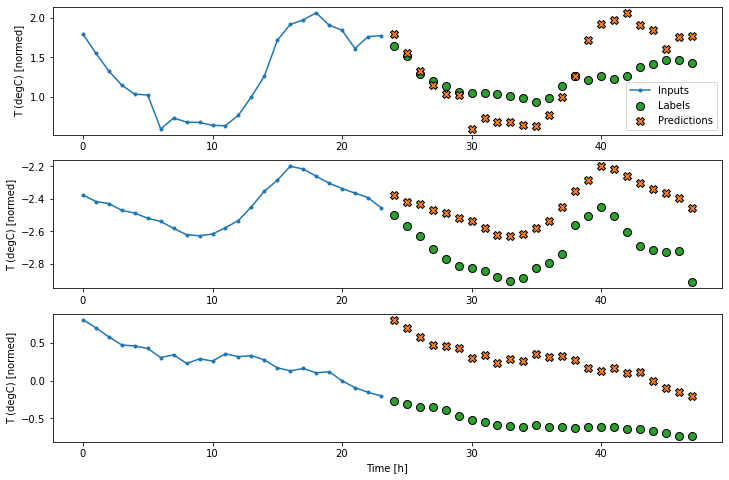

In [79]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### Single-shot

Jednym z zaawansowanych podejść do tego problemu jest użycie modelu "single-shot", w którym model dokonuje predykcji całej sekwencji w jednym kroku.

Można to wydajnie zaimplementować jako `layers.Dense` z jednostkami wyjściowymi `OUT_STEPS*features`. Model musi tylko przekształcić dane wyjściowe do wymaganych `(OUTPUT_STEPS, features)`.

#### Linear

Prosty model liniowy oparty na ostatnim wejściowym kroku czasowym działa lepiej niż którykolwiek z modeli baseline, ale nie ma wystarczającej mocy. Model musi przewidywać kroki czasowe `OUTPUT_STEPS` na podstawie jednego wejściowego kroku czasowego z projekcją liniową. Model ten może uchwycić jedynie niskowymiarowy wycinek zachowania, prawdopodobnie oparty głównie na porze dnia i roku.

![Predct all timesteps from the last time-step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_dense.png?raw=1)

In [ ]:
multi_linear_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]), #ostatni krok - [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Dense(OUT_STEPS*num_features, 
                          kernel_initializer=tf.initializers.zeros), #[batch, 1, out_steps*features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features]) #[batch, out_steps, features]
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

Epoch 1/20
1532/1532 [==============================] - 6s 3ms/step - loss: 0.3291 - mean_absolute_error: 0.3987 - val_loss: 0.2593 - val_mean_absolute_error: 0.3230
Epoch 2/20
1532/1532 [==============================] - 4s 3ms/step - loss: 0.2578 - mean_absolute_error: 0.3133 - val_loss: 0.2562 - val_mean_absolute_error: 0.3055
Epoch 3/20
 308/1532 [=====>........................] - ETA: 4s - loss: 0.2561 - mean_absolute_error: 0.3074

#### Dense

Dodanie `layers.Dense` między wejściem a wyjściem daje modelowi liniowemu większą moc, ale nadal jest on oparty tylko na jednym wejściowym kroku czasowym.

In [ ]:
multi_dense_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]), #ostatni krok [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Dense(512, activation='relu'), #[batch, 1, dense_units]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros), #[batch, out_steps*features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features]) #[batch, out_steps, features]
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

#### CNN

Model konwolucyjny dokonuje przewidywań na podstawie historii o stałej szerokości, co może prowadzić do lepszych wyników niż model gęsty, ponieważ widzi, jak rzeczy zmieniają się w czasie:

![A convolutional model sees how things change over time](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_conv.png?raw=1)

In [ ]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]), #[batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)), #[batch, 1, conv_units] 
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros), #[batch, 1,  out_steps*features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features]) #[batch, out_steps, features]
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

#### RNN

Model rekurencyjny może nauczyć się korzystać z długiej historii danych wejściowych, jeśli jest ona istotna dla przewidywań dokonywanych przez model. W tym przypadku model będzie gromadził stan wewnętrzny przez 24 godziny, a następnie dokona pojedynczego przewidywania na następne 24 godziny.

W tym formacie pojedynczego ujęcia LSTM musi wytworzyć wyjście tylko w ostatnim kroku czasowym, dlatego należy ustawić `return_sequences=False`.

![The lstm accumulates state over the input window, and makes a single prediction for the next 24h](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_lstm.png?raw=1)


In [ ]:
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False), #[batch, time, features] => [batch, lstm_units]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros), #[batch, out_steps*features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features]) #[batch, out_steps, features]
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

### Model autoregresyjny

Wszystkie powyższe modele przewidują całą sekwencję wyjściową jako pojedynczy krok.

W niektórych przypadkach pomocne może być podzielenie prognozy na poszczególne kroki czasowe. Wówczas dane wyjściowe każdego modelu mogą być wprowadzane do niego samego w każdym kroku, a przewidywania mogą być uzależnione od poprzedniego.

Jedną z wyraźnych zalet tego typu modelu jest to, że można go skonfigurować tak, by produkował dane wyjściowe o różnej długości.

Można wziąć dowolny z jednokrokowych modeli wielowyjściowych, wytrenowanych w pierwszej części tego poradnika, i uruchomić go w autoregresyjnej pętli sprzężenia zwrotnego, ale tutaj skupimy się na zbudowaniu modelu, który został specjalnie wytrenowany do tegp celu

![Feedback a model's output to its input](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_autoregressive.png?raw=1)


#### RNN

Ten tutorial buduje tylko autoregresyjny model RNN, ale schemat można zastosować do dowolnego modelu, który został zaprojektowany do wyprowadzania pojedynczego kroku czasowego.

Model będzie miał taką samą podstawową formę jak modele `LSTM` z pojedynczym krokiem czasowym: `LSTM`, po którym następuje `Dense`, który konwertuje dane wyjściowe `LSTM` na przewidywania modelu.

`LSTMCell` to `LSTM` w ujęciu bardziej niskopoziomowym, obiekt `LSTM` sam zarządza stanem i sekwencją wyników.

W tym przypadku model musi ręcznie zarządzać wejściami dla każdego kroku, więc używa `layers.LSTMCell`.

In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True) # zapakujmy LSTMcell w RNN dla ułatwienia warmupu
    self.dense = tf.keras.layers.Dense(num_features)

In [ ]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

Pierwszą metodą, jakiej potrzebuje ten model, jest metoda `warmup`, która inicjalizuje jego stan wewnętrzny na podstawie danych wejściowych. Po wytrenowaniu stan ten będzie przechwytywał istotne części historii danych wejściowych. Jest to odpowiednik wcześniejszego jednoetapowego modelu `LSTM`:

In [ ]:
def warmup(self, inputs):
  x, *state = self.lstm_rnn(inputs) #inputs.shape => (batch, time, features),  x.shape => (batch, lstm_units)
  prediction = self.dense(x)  # predictions.shape => (batch, features)
  return prediction, state

FeedBack.warmup = warmup

Metoda ta zwraca prognozę pojedynczego kroku czasowego oraz wewnętrzny stan LSTM:

In [ ]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

Mając stan `RNN` i początkowe przewidywania, można teraz kontynuować iterację modelu, podając przewidywania z każdego kroku z powrotem jako dane wejściowe.

Najprostszym podejściem do zbierania przewidywań wyjściowych jest użycie pythonowej listy i stackowanie po pętli.

In [ ]:
def call(self, inputs, training=None):
  predictions = []
  # zainicjalizuj stan LSTM
  prediction, state = self.warmup(inputs)

  # umieść pierwszą prognozę
  predictions.append(prediction)

  # przeprowadź resztę predykcji
  for n in range(1, self.out_steps):
    x = prediction # używa ostatnią prognozę jako wejście
    x, state = self.lstm_cell(x, states=state, training=training) # wykonuje jeden krok LSTM
    prediction = self.dense(x) # konwertuje wyjście LSTM na prognozę
    predictions.append(prediction) # dodaje prognozę do wyjścia

  predictions = tf.stack(predictions)  # (time, batch, features)
  predictions = tf.transpose(predictions, [1, 0, 2]) # (batch, time, features)
  return predictions

FeedBack.call = call

Przetestuj ten model na przykładowych danych wejściowych:

In [ ]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Teraz wytrenujmy model:

In [ ]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

### Wydajność

Najbardziej złożone modele wcale nie dają najlepszych wyników

In [ ]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

Metryki dla modeli wielowyjściowych w pierwszej połowie tego poradnika pokazują wydajność uśrednioną dla wszystkich cech wyjściowych. Wydajność ta jest podobna, ale również uśredniona dla wyjściowych przedziałów czasowych. 

In [ ]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Zysk uzyskany przy przejściu z modelu gęstego do modeli konwolucyjnych i rekurencyjnych wynosi zaledwie kilka procent (jeśli w ogóle), a model autoregresyjny okazał się wyraźnie gorszy. Tak więc te bardziej złożone podejścia mogą nie być warte zachodu w przypadku **tego** problemu, ale nie ma sposobu, aby się o tym przekonać, nie próbując, a te modele mogą być pomocne w przypadku **twojego** problemu.